# Tuning Machine Learning models in Spark

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

## ML Pipelines in Spark

ML model training and tuning often represents running the same steps once and again. Often, we run the same steps with small variations in order to evaluate combinations of parameters. 

In order to make this use case a lot easier, Spark provides the [Pipeline](https://spark.apache.org/docs/2.3.0/ml-pipeline.html) abstraction.

A Pipeline represents a series of steps in the processing of a dataset. Each step is a Transformer or an Estimator. The whole Pipeline is an Estimator, so we can .fit the whole pipeline in one step. When we do that, the steps'  .fit and .transform methods will be called in turn.

![pipelineestimator](https://spark.apache.org/docs/2.3.0/img/ml-Pipeline.png)

![PipelineModel](https://spark.apache.org/docs/2.3.0/img/ml-PipelineModel.png)

## Example: predicting flight delays

We'll be using the same [Transtats'](https://www.transtats.bts.gov/) OTP performance data] from way back when. Remember it?

It's a table that contains all domestic departures by US air air carriers that represent at least one percent of domestic scheduled passenger revenues, with data on each individual departure including [Tail Number](https://en.wikipedia.org/wiki/Tail_number), departure delay, origin, destination and carrier.


### Load the data

Opening .zip files in Spark is a bit of a pain. For now, let's just decompress the file we want to read. When we are ready to expand the processing to the cluster, we will need to do [this](https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark).

```python
csvname = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']
```

In [ ]:
!unzip -o On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_12.zip

In [ ]:
!ls -lrt

total 1228216
-rw-r--r--@ 1 aalmagro  staff  268702484 Mar 12  2019 input.csv
-rw-r--r--@ 1 aalmagro  staff  268702484 Mar 12  2019 On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv
-rw-r--r--@ 1 aalmagro  staff   82317299 Jun 27 08:53 coupon150720.csv
drwxr-xr-x  4 aalmagro  staff        128 Jul 10 16:35 clean
-rw-r--r--@ 1 aalmagro  staff      21513 Jul 10 16:37 04-working_on_cluster.ipynb
drwxr-xr-x  3 aalmagro  staff         96 Jul 10 18:55 kk
-rw-r--r--@ 1 aalmagro  staff       2134 Jul 10 18:57 myscript.py
-rw-r--r--@ 1 aalmagro  staff     651801 Jul 10 20:07 03_porting_to_spark_empty.ipynb
-rw-r--r--@ 1 aalmagro  staff     198174 Jul 10 20:09 05-ML_in_Spark.ipynb
drwxr-xr-x  9 aalmagro  staff        288 Jul 10 20:11 metastore_db
-rw-r--r--  1 aalmagro  staff        784 Jul 10 20:11 derby.log


In [ ]:
from pyspark.sql import SparkSession


csvname = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(csvname, header= True, inferSchema=True)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSe

In [ ]:
flights = df.select(columns_of_interest)

flights.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)



### Drop nas

There are only a few departures for which any of the columns of interest contains null values. The most expedient way to handle them is to just drop them, since they won't make much of a difference.

In [ ]:
flights.summary().show()

+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+------------------+------------------+-----------------+
|summary|  Year| Month|        DayofMonth|         DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|  Dest|DestCityName|DestStateName|           DepTime|          DepDelay|           AirTime|         Distance|
+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+------------------+------------------+-----------------+
|  count|593842|593842|            593842|            593842|           593842|     592744|                         593842|593842|        593842|         593842|593842|      593842|      

In [ ]:
flights.describe().show()

+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+------------------+------------------+-----------------+
|summary|  Year| Month|        DayofMonth|         DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|  Dest|DestCityName|DestStateName|           DepTime|          DepDelay|           AirTime|         Distance|
+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+------------------+------------------+-----------------+
|  count|593842|593842|            593842|            593842|           593842|     592744|                         593842|593842|        593842|         593842|593842|      593842|      

In [ ]:
flights.select("AirTime").show(20)

+-------+
|AirTime|
+-------+
|  111.0|
|  204.0|
|  207.0|
|  204.0|
|  205.0|
|  216.0|
|   64.0|
|   62.0|
|   62.0|
|   67.0|
|   62.0|
|   66.0|
|   62.0|
|   56.0|
|   52.0|
|   49.0|
|   51.0|
|   50.0|
|   54.0|
|   49.0|
+-------+
only showing top 20 rows



In [ ]:
flights.count()

593842

In [ ]:
from pyspark.sql import functions, types

flights.select(
    *[functions.sum(flights[col].isNull().cast(types.IntegerType())) for col in flights.columns]
).show()

+--------------------------------+---------------------------------+--------------------------------------+-------------------------------------+---------------------------------------------+---------------------------------------+-----------------------------------------------------------+----------------------------------+------------------------------------------+-------------------------------------------+--------------------------------+----------------------------------------+-----------------------------------------+-----------------------------------+------------------------------------+-----------------------------------+------------------------------------+
|sum(CAST((Year IS NULL) AS INT))|sum(CAST((Month IS NULL) AS INT))|sum(CAST((DayofMonth IS NULL) AS INT))|sum(CAST((DayOfWeek IS NULL) AS INT))|sum(CAST((Reporting_Airline IS NULL) AS INT))|sum(CAST((Tail_Number IS NULL) AS INT))|sum(CAST((Flight_Number_Reporting_Airline IS NULL) AS INT))|sum(CAST((Origin IS NULL) AS INT)

NA-related functions are grouped in a .na attribute of DataFrames.

In [ ]:
flights.na

In [ ]:
flights2 = flights.na.drop()

In [ ]:
flights2.summary().show(10)

+-------+------+------+------------------+-----------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+-----------------+------------------+------------------+-----------------+
|summary|  Year| Month|        DayofMonth|        DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|  Dest|DestCityName|DestStateName|          DepTime|          DepDelay|           AirTime|         Distance|
+-------+------+------+------------------+-----------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+-----------------+------------------+------------------+-----------------+
|  count|585737|585737|            585737|           585737|           585737|     585737|                         585737|585737|        585737|         585737|585737|      585737|       585737

## Feature extraction and generation of target variable

The departing hour is the most important factor in delays, so we need to calculate it from the departure time. Since the input file uses a funny format for times, Spark has interpreted them as floats:

In [ ]:
flights2.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)



In [ ]:
flights2.show(5)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+
|2018|   12|        25|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG| Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|
|2018|   12|        25|        2|               WN|     N562WN|                            982|   OAK|   Oakland, CA|     California| HOU| Houston, TX|        Texas|    638|    -2.0|  204.0|  1642.0|


In [ ]:
flights2.select('DepTime').show(5)

+-------+
|DepTime|
+-------+
|   1048|
|    638|
|   1710|
|   1318|
|    953|
+-------+
only showing top 5 rows



#### Exercise

Calculated the 'DepHour' column that represents the hour as an int.

In [ ]:
str(num)[:-2]

Implement this Extract hour function as UDF using str(num)[:-2]:

1) Define python function / Skip and lambda function.

2) Create udf object from function / lambda function.

3) Create new column (withColumn) using this udf.

In [ ]:
from pyspark.sql import functions, types

In [ ]:
time = 1034
def strHour(time):
    return int(str(time)[:-2])
strHour(time)

10

In [ ]:
takeHour_udf = functions.udf(lambda time:int(str(time)[:-2]),returnType=types.IntegerType())

In [ ]:
flights3b = flights2.withColumn("DepHour",takeHour_udf("DepTime").cast(types.IntegerType()))

In [ ]:
flights3 = flights2.withColumn('DepHour', (flights['DepTime'] / 100).cast(types.IntegerType()))

In [ ]:
flights3b.show(5)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|DepHour|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+
|2018|   12|        25|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG| Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|     10|
|2018|   12|        25|        2|               WN|     N562WN|                            982|   OAK|   Oakland, CA|     California| HOU| Houston, TX|        Texas|   

In [ ]:
flights3.count()

585737

In [ ]:
flights3b.count()

585737

In [ ]:
flights3b.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)



We will also generate a binary target variable. The aviation industry considers a flight delayed when it departs more than 15 minutes after its scheduled departure time, so we will use that. We will create it as an integer, since that is what the learning algorithms expect.

In [ ]:
flights4 = flights3.withColumn('Delayed', (flights3['DepDelay'] > 15).cast(types.IntegerType()))

In [ ]:
flights4.count()

585737

In order to make the training times manageable, let's pick only 10% of the data to train.

In [ ]:
train, rest = flights4.randomSplit([0.1, 0.9])

In [ ]:
train.show(10)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+------------------+---------------+----+------------------+--------------+-------+--------+-------+--------+-------+-------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|    OriginCityName|OriginStateName|Dest|      DestCityName| DestStateName|DepTime|DepDelay|AirTime|Distance|DepHour|Delayed|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+------------------+---------------+----+------------------+--------------+-------+--------+-------+--------+-------+-------+
|2018|   12|         1|        6|               F9|     N216FR|                            488|   DEN|        Denver, CO|       Colorado| RSW|    Fort Myers, FL|       Florida|     52|    -1.0|  201.0|  1607.0|      0|      0|
|2018|   12|         1|        6|               F9|     N216FR|                           15

## Handle different fields in different ways

We have features of at least three kinds:

* Numeric continuous fields, which we can use as input to many algorithms as they are. In particular, decision trees can take continuous variables with any value as input, since they only look for the cutoff point that most increases the homogeneity of the resulting groups. In contrast, if we were using a logistic regression with regularization, for example, we would need to first scale the variables to have comparable magnitudes.

* There are fields which we will treat as categorical variables, but which are already integers. These need to be one-hot encoded.

* Finally, there are several categorical variables that are encoded as strings. These need to be one-hot encoded, but OneHotEncoder requires numeric input. Therefore, we will need to apply a StringIndexer to each of them before one-hot encoding.

```python
# Reminder:

categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in flights_sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'
```

In [ ]:
train.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- Delayed: integer (nullable = true)



In [ ]:
train.schema

StructType(List(StructField(Year,IntegerType,true),StructField(Month,IntegerType,true),StructField(DayofMonth,IntegerType,true),StructField(DayOfWeek,IntegerType,true),StructField(Reporting_Airline,StringType,true),StructField(Tail_Number,StringType,true),StructField(Flight_Number_Reporting_Airline,IntegerType,true),StructField(Origin,StringType,true),StructField(OriginCityName,StringType,true),StructField(OriginStateName,StringType,true),StructField(Dest,StringType,true),StructField(DestCityName,StringType,true),StructField(DestStateName,StringType,true),StructField(DepTime,IntegerType,true),StructField(DepDelay,DoubleType,true),StructField(AirTime,DoubleType,true),StructField(Distance,DoubleType,true),StructField(DepHour,IntegerType,true),StructField(Delayed,IntegerType,true)))

In [ ]:
for field in train.schema.fields:
    print(field.name,field.dataType)

Year IntegerType
Month IntegerType
DayofMonth IntegerType
DayOfWeek IntegerType
Reporting_Airline StringType
Tail_Number StringType
Flight_Number_Reporting_Airline IntegerType
Origin StringType
OriginCityName StringType
OriginStateName StringType
Dest StringType
DestCityName StringType
DestStateName StringType
DepTime IntegerType
DepDelay DoubleType
AirTime DoubleType
Distance DoubleType
DepHour IntegerType
Delayed IntegerType


In [ ]:
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in train.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

We have generated the list of names of columns that have dataType string with a list comprehension, rather than hard-coding it, but it is just like the other ones.

In [ ]:
train.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- Delayed: integer (nullable = true)



## Handling categorical fields

Let's do the processing of just one field first, as an example. Then we will process the rest.

### StringIndexer 

A [StringIndexer](https://spark.apache.org/docs/2.2.0/ml-features.html#stringindexer) is an estimator that takes a single string field, then produces a transformer that codifies said field as numeric labels that are fit for feeding to a one-hot encoding. 

We need to specify an input column, an output column, and a way to handle invalids. In this case, invalids are values that the indexer has not seen during fitting but that the transformer finds during processing. Its values are 'error' (the default), which is pretty self-explanatory, 'skip', which drops them, and 'keep', which is what we want. It will assign all unseen labels to a single category index.

In [ ]:
from pyspark.ml.feature import StringIndexer

carrier_indexer = StringIndexer(inputCol='Reporting_Airline', outputCol='Reporting_Airline_index',\
                                handleInvalid='keep')

In [ ]:
carriers = train.select('Reporting_Airline')

In [ ]:
carrier_indexer_transformer = carrier_indexer.fit(carriers)

In [ ]:
carrier_indexer_transformer.transform(carriers2).show(5)

+-----------------+-----------------------+
|Reporting_Airline|Reporting_Airline_index|
+-----------------+-----------------------+
|               F9|                   14.0|
|               F9|                   14.0|
|               F9|                   14.0|
|               F9|                   14.0|
|               F9|                   14.0|
+-----------------+-----------------------+
only showing top 5 rows



### OneHotEncoder

A [OneHotEncoder](https://spark.apache.org/docs/latest/ml-features#onehotencoderestimator) generates a n-1 length vector column for an n-category column of category indices. 

We need to specify an input and an output column.

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator

onehot_encoder = OneHotEncoderEstimator(inputCols=['Reporting_Airline_index'], outputCols=['Reporting_Airline_onehot'])

In [ ]:
# The whole process for a single field would be like this:

carrier_indexer_transformer = carrier_indexer.fit(carriers)
indexed = carrier_indexer_transformer.transform(carriers)

onehot_encoder_model = onehot_encoder.fit(indexed)
onehot_encoded = onehot_encoder_model.transform(indexed)

onehot_encoded

DataFrame[Reporting_Airline: string, Reporting_Airline_index: double, Reporting_Airline_onehot: vector]

In [ ]:
onehot_encoded.show(5)

+-----------------+-----------------------+------------------------+
|Reporting_Airline|Reporting_Airline_index|Reporting_Airline_onehot|
+-----------------+-----------------------+------------------------+
|               F9|                   14.0|         (17,[14],[1.0])|
|               F9|                   14.0|         (17,[14],[1.0])|
|               F9|                   14.0|         (17,[14],[1.0])|
|               F9|                   14.0|         (17,[14],[1.0])|
|               F9|                   14.0|         (17,[14],[1.0])|
+-----------------+-----------------------+------------------------+
only showing top 5 rows



ModuleNotFoundError: ignored

### SparseVectors

The vectors produced by OneHotEncoder will each have only one non-zero value, but can potentially be very long. An efficient way to represent them is therefore a SparseVector, and that is what OneHotEncoder generates. 

A SparseVector is a data structure that only stores the length of the vector, a list of positions, and a list of values. All other values are assumed to be 0s.

This way, a vector like the following, with lenght 15 and non-zero values only on positions 3 and 9:

```python
[0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```

can be compactly expressed as

```python
(15, [3, 9], [6.0, 4.0])
```

In [ ]:
from pyspark.ml.linalg import SparseVector

## Let's build our first Pipeline!

Our pipeline consists of a number of StringIndexers, followed by one OneHotEncoder, followed by a VectorAssembler, with a RandomForestClassifier at the end.

A Spark Pipeline is a single Estimator. We build it secifying the stages it comprises, and then we are ready to .fit it in one go. This will save us a lot of trouble, since we don't need to fit and transform each stage individually.

In [ ]:
from pyspark.ml.pipeline import Pipeline

Pipeline

pyspark.ml.pipeline.Pipeline

### StringIndexer stages

We only need to StringIndex some of the fields. We are going to build the input and output column names programatically.


In [ ]:
# Reminder:

categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in train.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

In [ ]:
indexers = [StringIndexer(inputCol=field, outputCol=field + '_index', handleInvalid='keep') for field in string_fields]

In [ ]:
indexers

[StringIndexer_4064a7a3061aba4aa48f,
 StringIndexer_453ca8d5b7effe1e19c9,
 StringIndexer_4d199d9aee8eb0097d23,
 StringIndexer_498cb6027c097c104858,
 StringIndexer_496eaaaa62a759fa6162,
 StringIndexer_4a61b1b1ca29d0fc46c6,
 StringIndexer_41cfb78f039e052e570c,
 StringIndexer_445696072e4d39a1a1d1]

### OneHotEncoderEstimator

One OneHotEncoderEstimator can handle all categorical columns. We are also going to build it programatically

In [ ]:
non_string_categoricals = [field for field in categorical_fields if field not in string_fields]
non_string_categoricals

['Year', 'Month', 'DayofMonth', 'DayOfWeek']

In [ ]:
nsc_onehot_output = [ field + '_1hot' for field in non_string_categoricals]

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

In [ ]:
sc_onehot_input = [ field+'_index' for field in string_fields]
sc_onehot_output = [ field + '_1hot' for field in string_fields]

In [ ]:
nsc_onehot_output

['Year_1hot', 'Month_1hot', 'DayofMonth_1hot', 'DayOfWeek_1hot']

In [ ]:
sc_onehot_input 

['Reporting_Airline_index',
 'Tail_Number_index',
 'Origin_index',
 'OriginCityName_index',
 'OriginStateName_index',
 'Dest_index',
 'DestCityName_index',
 'DestStateName_index']

In [ ]:
sc_onehot_output

['Reporting_Airline_1hot',
 'Tail_Number_1hot',
 'Origin_1hot',
 'OriginCityName_1hot',
 'OriginStateName_1hot',
 'Dest_1hot',
 'DestCityName_1hot',
 'DestStateName_1hot']

In [ ]:
non_string_categoricals + sc_onehot_input

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Reporting_Airline_index',
 'Tail_Number_index',
 'Origin_index',
 'OriginCityName_index',
 'OriginStateName_index',
 'Dest_index',
 'DestCityName_index',
 'DestStateName_index']

In [ ]:
nsc_onehot_output + sc_onehot_output

['Year_1hot',
 'Month_1hot',
 'DayofMonth_1hot',
 'DayOfWeek_1hot',
 'Reporting_Airline_1hot',
 'Tail_Number_1hot',
 'Origin_1hot',
 'OriginCityName_1hot',
 'OriginStateName_1hot',
 'Dest_1hot',
 'DestCityName_1hot',
 'DestStateName_1hot']

In [ ]:
onehotencoder = OneHotEncoderEstimator(inputCols = non_string_categoricals + sc_onehot_input, 
                                       outputCols = nsc_onehot_output + sc_onehot_output)

### VectorAssembler

Once we have generated our features, we can assemble them into a single features column, together with the continuous_fields.

In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorAssembling = VectorAssembler(inputCols= nsc_onehot_output + sc_onehot_output + continuous_fields, 
                   outputCol='features')

# Full ML with Spark

## 1) PIPELINE preparation

### Steps:

0) Prepare label/target column.

1) String => StringIndex => Estimator called "indexers".

2) StringIndex => OneHotEncoding => Estimator called "onehotencoder".

3) Assembling Features => Assembling all features in the same column.

4) Prepare ML Model (Estimator).

==> Results on a Estimator

## 2) Fit the pipeline

## 3) Apply pipeline to test data in order to obtain predictions.


### RandomForestClassifier

Aaaaand we are ready to do some Machine Learning! We'll use a RandomForestClassifier to try to predict delayed versus non delayed flights, a binary classification task.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Delayed')

### Pipeline!

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [ ]:
indexers

[StringIndexer_4064a7a3061aba4aa48f,
 StringIndexer_453ca8d5b7effe1e19c9,
 StringIndexer_4d199d9aee8eb0097d23,
 StringIndexer_498cb6027c097c104858,
 StringIndexer_496eaaaa62a759fa6162,
 StringIndexer_4a61b1b1ca29d0fc46c6,
 StringIndexer_41cfb78f039e052e570c,
 StringIndexer_445696072e4d39a1a1d1]

In [ ]:
onehotencoder

OneHotEncoderEstimator_4edfadc3445c0608971f

In [ ]:
stages = indexers + [onehotencoder, vectorAssembling, rf_classifier]

In [ ]:
stages

[StringIndexer_4064a7a3061aba4aa48f,
 StringIndexer_453ca8d5b7effe1e19c9,
 StringIndexer_4d199d9aee8eb0097d23,
 StringIndexer_498cb6027c097c104858,
 StringIndexer_496eaaaa62a759fa6162,
 StringIndexer_4a61b1b1ca29d0fc46c6,
 StringIndexer_41cfb78f039e052e570c,
 StringIndexer_445696072e4d39a1a1d1,
 OneHotEncoderEstimator_4edfadc3445c0608971f,
 VectorAssembler_4d708870724074fa44e6,
 RandomForestClassifier_4db5b2a79c3c52e5f5e9]

In [ ]:
pipeline = Pipeline(stages=stages)

pipeline

Pipeline_412ab7ae34307a5ca9d8

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using a single Estimator:

In [ ]:
%%time

pipeline_model = pipeline.fit(train)

CPU times: user 94.7 ms, sys: 25.9 ms, total: 121 ms
Wall time: 2min 25s


In [ ]:
predicted = pipeline_model.transform(rest)
predicted

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, DepHour: int, Delayed: int, Reporting_Airline_index: double, Tail_Number_index: double, Origin_index: double, OriginCityName_index: double, OriginStateName_index: double, Dest_index: double, DestCityName_index: double, DestStateName_index: double, Origin_1hot: vector, Year_1hot: vector, Reporting_Airline_1hot: vector, OriginStateName_1hot: vector, DestStateName_1hot: vector, DayofMonth_1hot: vector, Dest_1hot: vector, Month_1hot: vector, OriginCityName_1hot: vector, Tail_Number_1hot: vector, DayOfWeek_1hot: vector, DestCityName_1hot: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predicted.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- Delayed: integer (nullable = true)
 |-- Reporting_Airline_index: double (nullable = false)
 |-- Tail_Number_index: double (nullable = false)
 |-- Origin_index: double (nullable = false)
 |-- OriginCityName_index: double

In [ ]:
predicted.select('probability').take(5)

[Row(probability=DenseVector([0.8293, 0.1707])),
 Row(probability=DenseVector([0.8244, 0.1756])),
 Row(probability=DenseVector([0.8244, 0.1756])),
 Row(probability=DenseVector([0.8159, 0.1841])),
 Row(probability=DenseVector([0.8347, 0.1653]))]

In [ ]:
predicted.select('prediction').take(5)

[Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=0.0)]

## Evaluating and tuning our Pipeline

Probably the most interesting use of Spark Pipelines is quickly (in terms of coding time) evaluating many combinations of hyperparameters to feed our model and choosing the best ones. For that, we can use a TrainValidationSplit or a CrossValidator. The CrossValidator will generally perform better, but it will take several times as much. I'm using here the TrainValidationSplit because the API is the same.

In [ ]:
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator

help(TrainValidationSplit)

Help on class TrainValidationSplit in module pyspark.ml.tuning:

class TrainValidationSplit(pyspark.ml.base.Estimator, ValidatorParams, pyspark.ml.param.shared.HasParallelism, pyspark.ml.util.MLReadable, pyspark.ml.util.MLWritable)
 |  .. note:: Experimental
 |  
 |  Validation for hyper-parameter tuning. Randomly splits the input dataset into train and
 |  validation sets, and uses evaluation metric on the validation set to select the best model.
 |  Similar to :class:`CrossValidator`, but only splits the set once.
 |  
 |  >>> from pyspark.ml.classification import LogisticRegression
 |  >>> from pyspark.ml.evaluation import BinaryClassificationEvaluator
 |  >>> from pyspark.ml.linalg import Vectors
 |  >>> dataset = spark.createDataFrame(
 |  ...     [(Vectors.dense([0.0]), 0.0),
 |  ...      (Vectors.dense([0.4]), 1.0),
 |  ...      (Vectors.dense([0.5]), 0.0),
 |  ...      (Vectors.dense([0.6]), 1.0),
 |  ...      (Vectors.dense([1.0]), 1.0)] * 10,
 |  ...     ["features", "label"]

### Params and Evaluators

In order to evaluate different sets of parameters, we need a) the set of parameters to iterate through and b) a metric to compare the results. 

The first element is represented by ParamMaps, which we build with a ParamGridBuilder, and the second by an Evaluator that needs to be specific to the relevant task.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

builder = ParamGridBuilder()

our_param_map = builder.addGrid(rf_classifier.maxDepth, [5, 15])\
                       .addGrid(rf_classifier.numTrees, [10, 30])\
                       .build()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

our_evaluator = BinaryClassificationEvaluator(labelCol='Delayed')

We now have all the elements in place to perform our fit:

In [ ]:
split = TrainValidationSplit(estimator=pipeline, 
                             evaluator=our_evaluator, 
                             estimatorParamMaps=our_param_map)

In [ ]:
%%time

split_model_chosen = split.fit(train)

CPU times: user 1.19 s, sys: 293 ms, total: 1.49 s
Wall time: 6min 49s


And now we can predict on the rest of the flights and compare them with reality:

In [ ]:
%%time

predictions = split_model_chosen.transform(rest).select('features',
                                                        'Delayed',
                                                        'rawPrediction',
                                                        'probability',
                                                        'prediction')

CPU times: user 32.8 ms, sys: 9.44 ms, total: 42.2 ms
Wall time: 347 ms


In [ ]:
predictions.show(20)

+--------------------+-------+--------------------+--------------------+----------+
|            features|Delayed|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8806,[2031,2067,...|      0|[25.0429376411858...|[0.83476458803952...|       0.0|
|(8806,[2031,2067,...|      0|[24.9557303434746...|[0.83185767811582...|       0.0|
|(8806,[2031,2067,...|      1|[24.9557303434746...|[0.83185767811582...|       0.0|
|(8806,[2031,2067,...|      1|[24.7473745611913...|[0.82491248537304...|       0.0|
|(8806,[2031,2067,...|      0|[24.9736225660102...|[0.83245408553367...|       0.0|
|(8806,[2031,2067,...|      0|[25.0620985385516...|[0.83540328461838...|       0.0|
|(8806,[2031,2067,...|      0|[25.3148713974201...|[0.84382904658067...|       0.0|
|(8806,[2031,2067,...|      0|[25.0726647085196...|[0.83575549028398...|       0.0|
|(8806,[2031,2067,...|      0|[25.0360989682475...|[0.83453663227491...|    

### Let's have a look

We are now ready to compare our predictions with reality. Do these features have any predictive power at all?

In [ ]:
predicted_probs = predictions.select('Delayed', 'probability').toPandas()

In [ ]:
y_true = predicted_probs['Delayed']
y_prob_predicted = predicted_probs['probability'].map(lambda vector: vector[1])

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob_predicted)

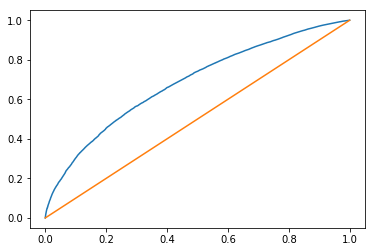

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 10), np.linspace(0,1, 10))

Not bad, considering we have not performed any feature engineering at all!

### Further Reading

https://spark.apache.org/docs/latest/ml-tuning.html

https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark

ModuleNotFoundError: ignored

In [ ]:
# Spark job for the cluster

from pyspark.sql import SparkSession, types, functions
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder


spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(csvname, header= True, inferSchema=True)

# Preprocessing
csvname = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']


# Feature extraction
flights = session.read.csv(csvname, header=True, inferSchema=True)
flights = flights.select(columns_of_interest)

flights = flights.na.drop()
flights = flights.withColumn('DepHour', (flights['DepTime'] / 100).cast(types.IntegerType()))
flights = flights.withColumn('Delayed', (flights['DepDelay'] > 15).cast(types.IntegerType()))

# Train/test split
flights_sample, rest = flights.randomSplit([.8, .2])

# Build the Pipeline
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in flights_sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'

indexers = [StringIndexer(inputCol=field, outputCol=field + 'Index', handleInvalid='keep') for field in string_fields]
non_string_categoricals = [field for field in categorical_fields if field not in string_fields]
non_string_categorical_onehotencoders = [OneHotEncoder(inputCol=field, outputCol=field + 'OneHot') for field in non_string_categoricals]
string_categorical_onehotencoders = [OneHotEncoder(inputCol=field+'Index', outputCol=field + 'OneHot') for field in string_fields]

input_cols_onehotencoded = [field + 'OneHot' for field in categorical_fields]

va = VectorAssembler(inputCols= input_cols_onehotencoded + continuous_fields, outputCol='features')

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Delayed')

pipeline = Pipeline(stages=indexers + 
                    string_categorical_onehotencoders + 
                    non_string_categorical_onehotencoders + 
                    [va] + 
                    [rf_classifier])

# Tuning and Training
builder = ParamGridBuilder()

our_param_map = builder.addGrid(rf_classifier.maxDepth, [5, 15])\
                       .addGrid(rf_classifier.numTrees, [10, 30])\
                       .build()        

our_evaluator = BinaryClassificationEvaluator(labelCol='Delayed')

split = TrainValidationSplit(estimator=pipeline, 
                             evaluator=our_evaluator, 
                             estimatorParamMaps=our_param_map)

split_model_chosen = split.fit(flights_sample)
predicted = split_model_chosen.transform(rest)
predictions = predicted.select('features',
                               'Delayed',
                               'rawPrediction',
                               'probability',
                               'prediction')

predicted.write.json('out/predicted')
split_model_chosen.bestModel.save('out/split_model_chosen')

ModuleNotFoundError: ignored

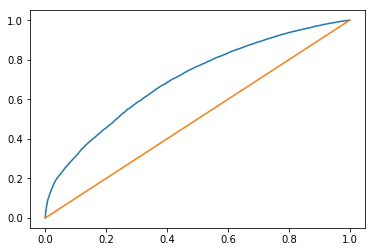

In [ ]:
# Check output
predicted_probs = predictions.select('Delayed', 'probability').toPandas()
y_true = predicted_probs['Delayed']
y_prob_predicted = predicted_probs['probability'].map(lambda vector: vector[1])

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob_predicted)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 10), np.linspace(0,1, 10))